In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats

#To plot data
import matplotlib.pyplot as plt
import seaborn as sns
from  statannot import add_stat_annotation #Helpful library to plot graphs: https://github.com/webermarcolivier/statannot

# Load Data

In [2]:
#Rename column names for easy access

columns_pre = ["Timestamp","ID", "Condition", "Gender", "Age", "Usage_Diffusers", "Bedroom_Size", "Bedroom_Door", "Airflow", "Prototype_ID"]

columns_smell = ["Timestamp","ID", "Condition","Prototype_ID", "Holder_ID", "Phone", "Smell", "Time_Smell", "Strength_Smell",
                 "Pleasant_Smell", "Smell1", "No_Smell2", "Smell3", "No_Smell4", "Smell5", "No_Smell6", "Smell7",
                 "No_Smell8", "No_Smell9", "Smell10"]

columns_post = ["Timestamp","ID", "Condition", "Trigger_Wake", "Sounds", "Sleep_Hours", "Sleep_Quality", "Sleep_Onset",
                "Deep", "Rest","Mood", "Dreams", "Smell_Sleep", "UX", "Prototype_ID"]

columns_final = ["Timestamp","ID", "Condition","Satisfaction","Aware_Smells", "Aware_Sounds","Aware_Prototype",
                "Wakeup","Smell_Quantity","Ideal_Burst", "Ideal_Frequency","Use","Owning","Pref_Fragrances",
                "Fragrances_day_night","Feedback","Mask","Ease_Refill","Time_Refill","Ease_Holder",
                "Ease_App","Design_prototype","Design_holder_prot","Prefer","Usage","Final_Feedback",
                "Prototype_ID"]

columns_followup = ["ID", "Condition","Typical_Sleep","Loud","Typical_Hours_Sleep","Notes"]

#Upload Data from user study surveys (Olfaction test, Pre-sleep, Post-Sleep, Final and Followup)
#exported from Excel as UTF-16 Unicode (.txt, changed to .tsv)

path = '../Data/'
path_plots = '../Plots/'

dfPre=pd.read_csv(path+'pre-sleep.tsv', delimiter='\t', usecols=columns_pre, encoding='UTF-16' ) #Olfaction Test Surveys
dfSmell=pd.read_csv(path+'smell.tsv',delimiter='\t', usecols=columns_smell, encoding='UTF-16' ) #Pre-sleep Surveys
dfPost=pd.read_csv(path+'post-sleep.tsv',delimiter='\t', usecols=columns_post, encoding='UTF-16' ) #Post-Sleep Surveys
dfFinal=pd.read_csv(path+'final.tsv', delimiter='\t', usecols=columns_final, encoding='UTF-16') #Final Surveys
# Remove participants that had issues with the prototype: p2, p3, p6, p5, p22 , p38, p36 & p7 because she didn't sleep because she had a test.
dfFinal = dfFinal[np.isin(dfFinal.ID, [2,3,5,6,7,22,36,38], invert=True)] 

dfFollowup=pd.read_csv(path+'followup.tsv', delimiter='\t', usecols=columns_followup, encoding='UTF-16') #Followup Surveyss

# Sleep quality 

### 1. Prepare data sleep quality

In [34]:
#Select only those participants that appear in both surveys based on ID
df_followup = pd.merge(dfPost, dfFollowup, how='inner', on=['ID','Condition'])

# Remove participants that had issues with the prototype: p2, p3, p6, p5, p22 , p38, p36 & p7 because she didn't sleep because she had a test. 
# p1, p10, p20 don't appear because they did not finish the study
# These are the same participants we removed for the other analysis as well
df_followup = df_followup[np.isin(df_followup.ID, [2,3,5,6,7,22,36,38], invert=True)]

#Make a dataframe with only 4 columns (for sleep quality)
df_sleep = df_followup.filter(items=['ID','Condition','Sleep_Quality','Typical_Sleep'])

# We now calculate the difference between sleep quality on a typical night and a night using the prototype and add this as a new column.
df_sleep['difference_sleep'] = df_followup['Sleep_Quality'] - df_followup['Typical_Sleep']

#There are 2 ways to calculate this. One is relative to the user. Setting to 100% their original sleep:
#Relative change with respect to a typical night
df_sleep['percentage_sleep'] = 100*((df_followup['Sleep_Quality']-df_followup['Typical_Sleep']) / df_followup['Typical_Sleep'])

#The other is setting a max value that can reach (in this case +6 or -6)
#df_sleep['percentage_sleep'] = ( (df_sleep['difference_sleep'])*100 )/6

# Select those participants in scent or control condition
scent_sleep = df_sleep[df_sleep.Condition == 0 ].percentage_sleep
control_sleep = df_sleep[df_sleep.Condition == 1 ].percentage_sleep


### 2. Calculate stats sleep quality & check assumptions 

In [35]:
# Calculate Mean 
m_control_sleep = round (control_sleep.mean() , 2)
m_scent_sleep = round (scent_sleep.mean(), 2)

# Calculate Standard Deviation
sd_control_sleep = round (control_sleep.std() , 2)
sd_scent_sleep = round (scent_sleep.std(), 2)

# Calculate Standard Error Mean
sem_control_sleep = round (control_sleep.sem() , 2)
sem_scent_sleep = round (scent_sleep.sem(), 2)

# Calculate Median
median_control_sleep = round (control_sleep.median() , 2)
median_scent_sleep = round (scent_sleep.median(), 2)

print("---- Descriptive Statistics Control ----")
print("M: ", m_control_sleep)
print("Median: ", median_control_sleep)
print("SEM: ", sem_control_sleep)
print("SD: ", sd_control_sleep)

print("---- Descriptive Statistics Scent ----")
print("M: ", m_scent_sleep)
print("Median: ", median_scent_sleep)
print("SEM: ", sem_scent_sleep)
print("SD: ", sd_scent_sleep)


# Before we apply any statistical controls, we check the normality and variance criteria:
#All t-tests assume that your data follow the normal distribution.

---- Descriptive Statistics Control ----
M:  -2.24
Median:  0.0
SEM:  4.63
SD:  17.95
---- Descriptive Statistics Scent ----
M:  19.29
Median:  10.0
SEM:  5.88
SD:  22.0


#### 2.1. Assumptions

##### 2.1.1 Normality (Shapiro–Wilk Test). Additionally, we check for skewness & kurtosis

In [5]:
# One of the assumptions is that the sampling distribution is normally distributed. One method for testing this assumption is the Shapiro-Wilk test. 

pvalueControlNormality = sp.stats.shapiro(control_sleep.dropna()).pvalue # Shapiro-Wilk normality test for Control group 
pvalueScentNormality = sp.stats.shapiro(scent_sleep.dropna()).pvalue # Shapiro-Wilk normality test for Scent group 

#Let's check how symmetrical & skewed is the data (particularly for scent group)
#We use the argument bias=False to calculate the sample skewness and kurtosis as opposed to the population skewness and kurtosis.

skewControl = sp.stats.skew(control_sleep,bias = False)
skewScent = sp.stats.skew(scent_sleep,bias = False)
kurtControl =  sp.stats.kurtosis(control_sleep, fisher=True, bias = False)
kurtScent =  sp.stats.kurtosis(scent_sleep, fisher=True, bias = False)


# PRINT RESULTS
print("")

print("------- Normality Control Group: ------- ", )
pvalueNormality = pvalueControlNormality
skew = skewControl
kurt = kurtControl

if 5.00e-02 > pvalueNormality <= 1.00e+00:
    print("    Data is not close to a normal distribution because p>0.05 (differs from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )

else: 
    print("    Data follows a normal distribution because p>0.05 (not very different from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )
  
if skew -0.5<= skew <=0.5:
        print("    The distribution is fairly symmetrical: ")

if skew  <0:
    print("    The distribution is negatively skewed: ") 
else: 
    print("    The distribution is positively skewed: ") 

print("           skewness = ", round(skew,3) )  

if kurt  <0:
    print("    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): ") 
else: 
    print("    The distribution is long-tailed (has a higher kurtosis, thus a heavier tail): ") 

        
print("           kurtosis = ", round(kurt,3) )  


print("")

print("------- Normality Scent Group: ------- ", )
pvalueNormality = pvalueScentNormality
skew = skewScent
kurt = kurtScent

if 5.00e-02 > pvalueNormality <= 1.00e+00:
    print("    Data is not close to a normal distribution because p>0.05 (differs from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )

else: 
    print("    Data follows a normal distribution because p>0.05 (not very different from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )
  

if -0.5<= skew <=0.5:
        print("    The distribution is fairly symmetrical: ")
else:
    if skew  <0:
        print("    The distribution is negatively skewed: ") 
    else: 
        print("    The distribution is positively skewed: ") 

print("           skewness = ", round(skew,3) )  


if kurt  <0:
    print("    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): ") 
else: 
    print("    The distribution is long-tailed (has a higher kurtosis, thus a heavier tail): ") 

        
print("           kurtosis = ", round(kurt,3) )  

print("")



------- Normality Control Group: ------- 
    Data follows a normal distribution because p>0.05 (not very different from a normal distribution): 
           p= 0.229
    The distribution is fairly symmetrical: 
    The distribution is negatively skewed: 
           skewness =  -0.156
    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): 
           kurtosis =  -0.837

------- Normality Scent Group: ------- 
    Data is not close to a normal distribution because p>0.05 (differs from a normal distribution): 
           p= 0.002
    The distribution is fairly symmetrical: 
           skewness =  0.459
    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): 
           kurtosis =  -1.748



##### 2.a.2) Variance

In [6]:
# To test for variance we apply the Levene test. The variance criterion holds true when p > a (where a is the probability threshold set to 0.05)
levenePvalue = sp.stats.levene(control_sleep, scent_sleep).pvalue
print("Levene Test: ",round(levenePvalue,4))
# As p > 0.05 
if levenePvalue  >0.05:
    print("    A non-significant p value (larger than 0.05) of levene's test show that the variances of both groups are not significantly different, thus we can proceed using tests for equal variances") 
else: 
    print("    Not equal variances. A significant p value (larger than 0.05) of levene's test show that the variances of both groups are significantly different.") 


Levene Test:  0.1998
    A non-significant p value (larger than 0.05) of levene's test show that the variances of both groups are not significantly different, thus we can proceed using tests for equal variances


##### 2.a.3) Samples are independent

In [7]:
# This assumption was tested when the study was designed, hence no individual has data in group A (scent) and B (control). No calculation is needed.

### 3. Plots sleep quality 

In [8]:
#We run both parametric and non-parametric tests to validate our results because the control group follows a normal distribution & scent group is only moderately skewed 

##### 2.a.3) Plots for parametric Independent t-test

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=7.411e-03 stat=2.896e+00
-----------------------------------------------------------------------------------
Judith's Notes:
Plotted 2-tail p-value statannot:    0.00741
1-tail p-value statannot:            0.00371
Here are the number of stars that should be plotted, otherwise they are added manually:
**
-----------------------------------------------------------------------------------

StatResult attributes: t-test independent samples, P_val=7.411e-03 stat=2.896e+00


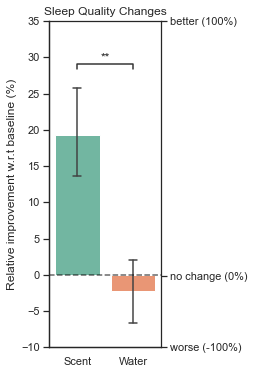

In [9]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "percentage_sleep"

#Convert Condition to string so we can use the library
df_sleep.Condition = df_sleep.Condition.astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_sleep, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_sleep, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)

# We can also use our own p-values that I calculated above instead of the one from the statanot library
# ax, test_results = add_stat_annotation(ax, data=df_sleep, x=x, y=y, order=order,
#                                    box_pairs=[tuple(order)],
#                                    pvalues = [p_sleep],
#                                    perform_stat_test=False,
#                                    test=None, comparisons_correction=None, text_format='star',
#                                    loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='Relative improvement w.r.t baseline (%)', title = 'Sleep Quality Changes')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-10,35)
ax2 = ax.twinx()
positions = (22, 100, 0)
labels = ("no change (0%)", "better (100%)", "worse (-100%)")


plt.yticks(positions, labels)
# Save the image
# ATTENTION! This is a 2-tail test. To know 1-tail = (test_results[0].pval)/2

print("-----------------------------------------------------------------------------------")
print("Judith's Notes:")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))
print("Here are the number of stars that should be plotted, otherwise they are added manually:")

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")
print("-----------------------------------------------------------------------------------")

print("\nStatResult attributes:", test_results[0])

plt.savefig(path_plots+'sleepquality_t-test.png', dpi=300, bbox_inches='tight')

##### Additional plots for non-parametric Mann-Whitney U Test

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=1.823e-02 U_stat=1.570e+02
-----------------------------------------------------------------------------------
Judith's Notes:
Plotted 2-tail p-value statannot:    0.01823
1-tail p-value statannot:            0.00912
Here are the number of stars that should be plotted, otherwise they are added manually:
**
-----------------------------------------------------------------------------------


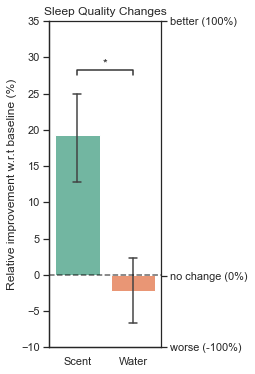

In [10]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "percentage_sleep"

#Convert Condition to string so we can use the library
df_sleep.Condition = df_sleep.Condition.astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_sleep, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_sleep, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


ax.set(xlabel='', ylabel='Relative improvement w.r.t baseline (%)', title = 'Sleep Quality Changes')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-10,35)
ax2 = ax.twinx()
positions = (22, 100, 0)
labels = ("no change (0%)", "better (100%)", "worse (-100%)")


plt.yticks(positions, labels)
# Save the image
# ATTENTION! This is a 2-tail test. To know 1-tail = (test_results[0].pval)/2

print("-----------------------------------------------------------------------------------")
print("Judith's Notes:")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))
print("Here are the number of stars that should be plotted, otherwise they are added manually:")

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")
print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'sleepquality_mann.png', dpi=300, bbox_inches='tight')

# Deep/Rest/Mood/Dreams/Onset

### Prepare data 

In [11]:
df_post = dfPost.filter(items=['ID','Condition','Sleep_Onset','Deep', 'Rest', 'Mood', 'Dreams'])

# Remove participants that had issues with the prototype: p2, p3, p6, p5, p22 , p38, p36 & p7 because she didn't sleep because she had a test. 
# p1, p10, p20 don't appear because they did not finish the study
# These are the same participants we removed for the other analysis as well
df_post = df_post[np.isin(df_post.ID, [2,3,5,6,7,22,36,38], invert=True)]

# Replace average/better/worse texts with numbers
avg = 0
better = 100
worse = -100

df_post = df_post.replace(regex=['Deeper', 'More rested', 'More positive', 'It took me LESS time to fall sleep'], value = better)
df_post = df_post.replace(regex=['Average', 'same'], value = avg)
df_post = df_post.replace(regex=['Less rested', 'Less positive','It took me MORE time to fall sleep'], value = worse)

In [12]:
#Some participants reported not having dreams

p4_d = "No dreams" #We don't know if it's positive or negative dreams
p15_d = "Less dream" #We don't know if it's positive or negative dreams
p14_d = "No dream" #We don't know if it's positive or negative dreams
p23_d = "Don't remember any dreams" #We don't know if it's positive or negative dreams
p25_d = "Don't dream that often"
p27_d = "Can't remember"
p28_d = "I don't remember"
p33_d = "I can't remember"

#Replace their text with "avg" so we don't take it into account
df_post = df_post.replace(regex=[p4_d,p15_d,p14_d,p23_d,p25_d,p27_d,p28_d,p33_d], value = avg)

#Some participants had other causes that might have influenced them:
p9_m = "I woke up pretty early and fresh - also excited for the day. I'm not in my regular housing / city / environment, just to be taken into account."
df_post = df_post.replace(regex=[p9_m], value = better)

p28_m = "Less postive because I woke up later that regular"
df_post = df_post.replace(regex=[p28_m], value = worse)

p39_m = "Different" #We don't know if it's positive or negative mood
df_post = df_post.replace(regex=[p28_m, p39_m], value = avg)


### Assumptions

In [31]:
# Uncomment accordinglly to run stats & check normality for each variable (Mood, Deep, Sleep_Onset, Rest, Dreams)

# Select those participants in scent or control condition
#scent_sleep = df_post[df_post.Condition == 0 ].Mood
#control_sleep = df_post[df_post.Condition == 1 ].Mood

#scent_sleep = df_post[df_post.Condition == 0 ].Deep
#control_sleep = df_post[df_post.Condition == 1 ].Deep

#scent_sleep = df_post[df_post.Condition == 0 ].Rest
#control_sleep = df_post[df_post.Condition == 1 ].Rest

#scent_sleep = df_post[df_post.Condition == 0 ].Dreams
#control_sleep = df_post[df_post.Condition == 1 ].Dreams

scent_sleep = df_post[df_post.Condition == 0 ].Sleep_Onset
control_sleep = df_post[df_post.Condition == 1 ].Sleep_Onset


In [32]:
#Descriptive Stats

# Calculate Mean 
m_control_sleep = round (control_sleep.mean() , 2)
m_scent_sleep = round (scent_sleep.mean(), 2)

# Calculate Standard Deviation
sd_control_sleep = round (control_sleep.std() , 2)
sd_scent_sleep = round (scent_sleep.std(), 2)

# Calculate Standard Error Mean
sem_control_sleep = round (control_sleep.sem() , 2)
sem_scent_sleep = round (scent_sleep.sem(), 2)

# Calculate Median
median_control_sleep = round (control_sleep.median() , 2)
median_scent_sleep = round (scent_sleep.median(), 2)

print("---- Descriptive Statistics Control ----")
print("M: ", m_control_sleep)
print("Median: ", median_control_sleep)
print("SEM: ", sem_control_sleep)
print("SD: ", sd_control_sleep)

print("---- Descriptive Statistics Scent ----")
print("M: ", m_scent_sleep)
print("Median: ", median_scent_sleep)
print("SEM: ", sem_scent_sleep)
print("SD: ", sd_scent_sleep)


# Before we apply any statistical controls, we check the normality and variance criteria:
#All t-tests assume that your data follow the normal distribution.

---- Descriptive Statistics Control ----
M:  -20.0
Median:  0.0
SEM:  17.46
SD:  67.61
---- Descriptive Statistics Scent ----
M:  42.86
Median:  50.0
SEM:  17.27
SD:  64.62


### Sleep Onset Plots & stats

#### 2.1. Assumptions

##### 2.1.1 Normality (Shapiro–Wilk Test). Additionally, we check for skewness & kurtosis

In [14]:
# One of the assumptions is that the sampling distribution is normally distributed. One method for testing this assumption is the Shapiro-Wilk test. 

pvalueControlNormality = sp.stats.shapiro(control_sleep.dropna()).pvalue # Shapiro-Wilk normality test for Control group 
pvalueScentNormality = sp.stats.shapiro(scent_sleep.dropna()).pvalue # Shapiro-Wilk normality test for Scent group 

#Let's check how symmetrical & skewed is the data (particularly for scent group)
#We use the argument bias=False to calculate the sample skewness and kurtosis as opposed to the population skewness and kurtosis.

skewControl = sp.stats.skew(control_sleep,bias = False)
skewScent = sp.stats.skew(scent_sleep,bias = False)
kurtControl =  sp.stats.kurtosis(control_sleep, fisher=True, bias = False)
kurtScent =  sp.stats.kurtosis(scent_sleep, fisher=True, bias = False)


# PRINT RESULTS
print("")

print("------- Normality Control Group: ------- ", )
pvalueNormality = pvalueControlNormality
skew = skewControl
kurt = kurtControl

if 5.00e-02 > pvalueNormality <= 1.00e+00:
    print("    Data is not close to a normal distribution because p>0.05 (differs from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )

else: 
    print("    Data follows a normal distribution because p>0.05 (not very different from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )
  
if skew -0.5<= skew <=0.5:
        print("    The distribution is fairly symmetrical: ")

if skew  <0:
    print("    The distribution is negatively skewed: ") 
else: 
    print("    The distribution is positively skewed: ") 

print("           skewness = ", round(skew,3) )  

if kurt  <0:
    print("    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): ") 
else: 
    print("    The distribution is long-tailed (has a higher kurtosis, thus a heavier tail): ") 

        
print("           kurtosis = ", round(kurt,3) )  


print("")

print("------- Normality Scent Group: ------- ", )
pvalueNormality = pvalueScentNormality
skew = skewScent
kurt = kurtScent

if 5.00e-02 > pvalueNormality <= 1.00e+00:
    print("    Data is not close to a normal distribution because p>0.05 (differs from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )

else: 
    print("    Data follows a normal distribution because p>0.05 (not very different from a normal distribution): ")
    print("           p=", round(pvalueNormality,3) )
  

if -0.5<= skew <=0.5:
        print("    The distribution is fairly symmetrical: ")
else:
    if skew  <0:
        print("    The distribution is negatively skewed: ") 
    else: 
        print("    The distribution is positively skewed: ") 

print("           skewness = ", round(skew,3) )  


if kurt  <0:
    print("    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): ") 
else: 
    print("    The distribution is long-tailed (has a higher kurtosis, thus a heavier tail): ") 

        
print("           kurtosis = ", round(kurt,3) )  

print("")



------- Normality Control Group: ------- 
    Data is not close to a normal distribution because p>0.05 (differs from a normal distribution): 
           p= 0.004
    The distribution is fairly symmetrical: 
    The distribution is positively skewed: 
           skewness =  0.256
    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): 
           kurtosis =  -0.505

------- Normality Scent Group: ------- 
    Data is not close to a normal distribution because p>0.05 (differs from a normal distribution): 
           p= 0.002
    The distribution is negatively skewed: 
           skewness =  -0.692
    The distribution is short-tailed (has a lower kurtosis, thus a thinner tail): 
           kurtosis =  -0.252



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=2.035e-02 U_stat=1.545e+02
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.02035
1-tail p-value statannot:            0.01017
*
-----------------------------------------------------------------------------------


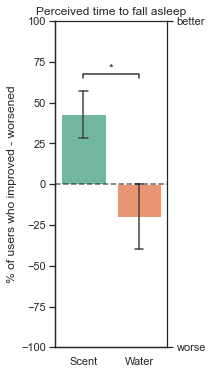

In [15]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Sleep_Onset"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typical night

ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Perceived time to fall asleep')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'sleeponset_mann.png', dpi=300, bbox_inches='tight')

In [16]:
###Old plots for parametric independent t-test (this is not correct because we are violating one of thea assumptions -> normality). Thus Mann Whitney U Test should be used.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=1.655e-02 stat=2.556e+00
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.01655
1-tail p-value statannot:            0.00827
The number of stars might need to manually added because statannot does 2-tail instead of 1-tail
**
-----------------------------------------------------------------------------------


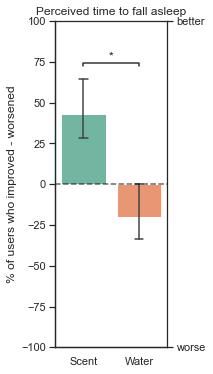

In [17]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Sleep_Onset"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Perceived time to fall asleep')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))
print("The number of stars might need to manually added because statannot does 2-tail instead of 1-tail")

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'sleeponset_t-tes.png', dpi=300, bbox_inches='tight')

### Rest Plots & stats

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=4.948e-01 U_stat=1.190e+02
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.49480
1-tail p-value statannot:            0.24740
ns
-----------------------------------------------------------------------------------


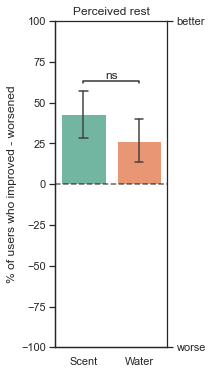

In [18]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Rest"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night
ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Perceived rest')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)


print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'rest_mann.png', dpi=300, bbox_inches='tight')

In [19]:
###Old plots for parametric independent t-test (this is not correct because we are violating one of thea assumptions -> normality). Thus Mann Whitney U Test should be used.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=4.405e-01 stat=7.829e-01
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.44051
1-tail p-value statannot:            0.22025
ns
-----------------------------------------------------------------------------------


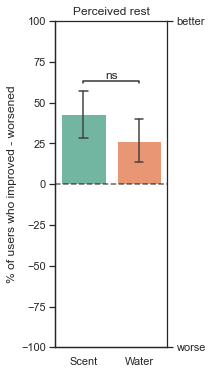

In [20]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Rest"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night
ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Perceived rest')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)


print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'rest_t_test.png', dpi=300, bbox_inches='tight')

### Deep Sleep Plots & stats

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=6.220e-01 U_stat=1.150e+02
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.62198
1-tail p-value statannot:            0.31099
ns
-----------------------------------------------------------------------------------


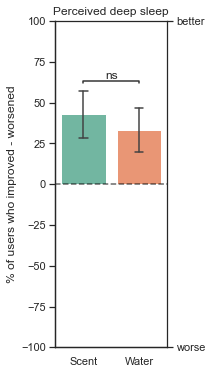

In [21]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Deep"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Perceived deep sleep')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'deep_mann.png', dpi=300, bbox_inches='tight')

In [22]:
###Old plots for parametric independent t-test (this is not correct because we are violating one of thea assumptions -> normality). Thus Mann Whitney U Test should be used.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=6.127e-01 stat=5.121e-01
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.61273
1-tail p-value statannot:            0.30637
ns
-----------------------------------------------------------------------------------


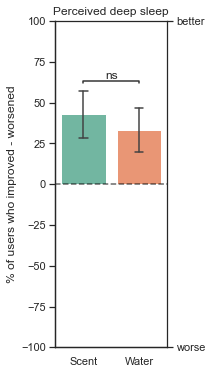

In [23]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Deep"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Perceived deep sleep')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'deep_.png', dpi=300, bbox_inches='tight')

### Mood Plots & stats

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=8.737e-02 U_stat=1.400e+02
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.08737
1-tail p-value statannot:            0.04369
*
-----------------------------------------------------------------------------------


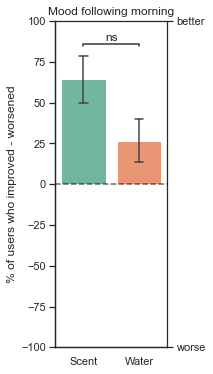

In [24]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Mood"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night
ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Mood following morning')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)


print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'mood_mann.png', dpi=300, bbox_inches='tight')

In [25]:
###Old plots for parametric independent t-test (this is not correct because we are violating one of thea assumptions -> normality). Thus Mann Whitney U Test should be used.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=7.636e-02 stat=1.843e+00
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.07636
1-tail p-value statannot:            0.03818
*
-----------------------------------------------------------------------------------


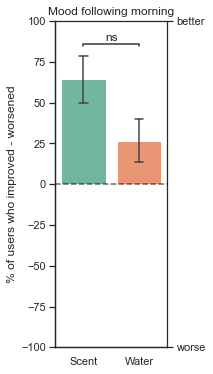

In [26]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Mood"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night
ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Mood following morning')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)


print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'mood.png', dpi=300, bbox_inches='tight')

### Dream Plots & stats

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=5.157e-01 U_stat=1.180e+02
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.51570
1-tail p-value statannot:            0.25785
ns
-----------------------------------------------------------------------------------


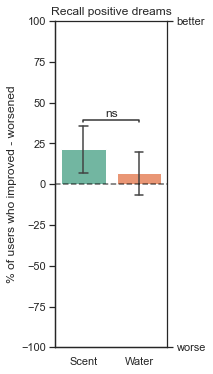

In [27]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Dreams"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Recall positive dreams')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)


print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'dreams_mann.png', dpi=300, bbox_inches='tight')

#df_post

In [28]:
###Old plots for parametric independent t-test (this is not correct because we are violating one of thea assumptions -> normality). Thus Mann Whitney U Test should be used.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=5.040e-01 stat=6.772e-01
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.50404
1-tail p-value statannot:            0.25202
ns
-----------------------------------------------------------------------------------


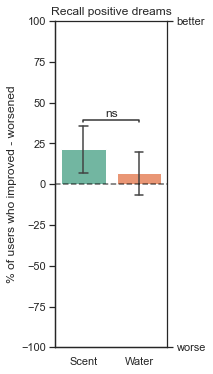

In [29]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Dreams"

#Convert Condition to string so we can use the library
df_post.Condition = df_post.Condition.astype(str)

order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_post, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_post, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='% of users who improved - worsened', title = 'Recall positive dreams')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(-100,100)
ax2 = ax.twinx()
positions = (100, 0)
labels = ("better", "worse")


plt.yticks(positions, labels)


print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'dreams_t-test.png', dpi=300, bbox_inches='tight')

#df_post

# Hedonics

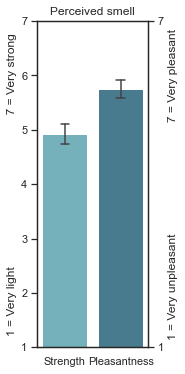

In [30]:
dfSmell_filt = dfSmell.filter(items=['ID','Strength_Smell','Pleasant_Smell'])
dfSmell_filt.columns = ['ID','Strength','Pleasantness']
dfSmell_filt = pd.melt(dfSmell_filt, value_vars=['Strength', 'Pleasantness'])

fig , ax = plt.subplots(figsize=(2,6))
sns.barplot(x = 'variable', y='value',  data = dfSmell_filt,
            errwidth=1.5, capsize=0.15, palette="GnBu_d", ci=68, ax = ax)
#ax.set_title('Hedonics')
ax.set(xlabel='', ylabel='1 = Very light                                             7 = Very strong', 
       title = 'Perceived smell')

ax2 = ax.twinx()
ax2.set(xlabel='', ylabel='1 = Very unpleasant                                 7 = Very pleasant')
ax2.set_ylim(1,7)
positions = (1,7)
#labels = ("best", "worst")
plt.yticks(positions)

ax.set_ylim(1,7)
ax.set_xlabel('')
plt.savefig(path_plots+'hedonics.png', dpi=300, bbox_inches='tight')
plt.show()



# Awareness & Awakenings

### 1. Prepare data awareness & awakenings

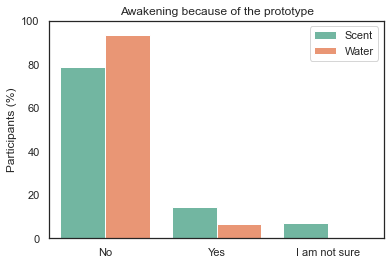

,Condition,Wakeup,Participants (%)
0,Scent,No,78.571429
1,Scent,Yes,14.285714
2,Scent,I am not sure,7.142857
3,Water,No,93.333333
4,Water,Yes,6.666667


In [45]:
#Make a dataframe with only 4 columns (for sleep quality)
df_final = dfFinal.filter(items=['ID','Condition','Aware_Smells','Aware_Sounds','Aware_Prototype','Wakeup'])

df_final['awakenings'] = df_final.Wakeup
df_final.Condition = df_final.Condition.map({0.0: 'Scent', 1.0:'Water'}) #Scent condition is set to 0, Control condition to 1.
x,y,hue='Wakeup', 'Participants (%)', 'Condition'
palette = 'Set2'

# need to compute percentages before
prop_df = (df_final[x]
           .groupby(df_final[hue])
           .value_counts(normalize=True)
           .multiply(100)
           .rename(y)
           .reset_index())

fig , ax = plt.subplots()
sns.barplot(x = x, y=y, hue = hue, data = prop_df, palette=palette, ax = ax)
ax.set_title('Awakening because of the prototype')
ax.set_xlabel('')
ax.set_ylim(0,100)
plt.legend(loc=1)
plt.savefig(path_plots+'awakening.png', dpi=300, bbox_inches='tight')
plt.show()

prop_df


### 2. Calculate stats sleep quality & check assumptions 

In [48]:
# Uncomment accordinglly to run stats & check normality for each variable (Aware_Smells, Aware_Sounds, Aware_Prototype)

# Select those participants in scent or control condition
#scent_sleep = df_final[dfFinal.Condition == 0 ].Aware_Smells
#control_sleep = df_final[dfFinal.Condition == 1 ].Aware_Smells

#scent_sleep = df_final[dfFinal.Condition == 0 ].Aware_Sounds
#control_sleep = df_final[dfFinal.Condition == 1 ].Aware_Sounds

scent_sleep = df_final[dfFinal.Condition == 0 ].Aware_Prototype
control_sleep = df_final[dfFinal.Condition == 1 ].Aware_Prototype


In [49]:
# Calculate Mean 
m_control_sleep = round (control_sleep.mean() , 2)
m_scent_sleep = round (scent_sleep.mean(), 2)

# Calculate Standard Deviation
sd_control_sleep = round (control_sleep.std() , 2)
sd_scent_sleep = round (scent_sleep.std(), 2)

# Calculate Standard Error Mean
sem_control_sleep = round (control_sleep.sem() , 2)
sem_scent_sleep = round (scent_sleep.sem(), 2)

# Calculate Median
median_control_sleep = round (control_sleep.median() , 2)
median_scent_sleep = round (scent_sleep.median(), 2)

print("---- Descriptive Statistics Control ----")
print("M: ", m_control_sleep)
print("Median: ", median_control_sleep)
print("SEM: ", sem_control_sleep)
print("SD: ", sd_control_sleep)

print("---- Descriptive Statistics Scent ----")
print("M: ", m_scent_sleep)
print("Median: ", median_scent_sleep)
print("SEM: ", sem_scent_sleep)
print("SD: ", sd_scent_sleep)


# Before we apply any statistical controls, we check the normality and variance criteria:
#All t-tests assume that your data follow the normal distribution.

---- Descriptive Statistics Control ----
M:  5.07
Median:  5.0
SEM:  0.5
SD:  1.94
---- Descriptive Statistics Scent ----
M:  5.29
Median:  6.0
SEM:  0.44
SD:  1.64


### 2.a) Plots awareness of prototye (using statannot)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=7.463e-01 stat=3.269e-01
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.74627
1-tail p-value statannot:            0.37313
ns
-----------------------------------------------------------------------------------


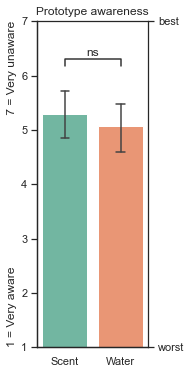

In [32]:
df_final = dfFinal.filter(items=['ID','Condition','Aware_Smells','Aware_Sounds','Aware_Prototype','Wakeup'])
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Aware_Prototype"

#Convert Condition to string so we can use the library
df_final.Condition = df_final.Condition.astype(int).astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_final, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_final, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='1 = Very aware                                             7 = Very unaware', 
       title = 'Prototype awareness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(1,7)
ax2 = ax.twinx()
positions = (7, 0)
labels = ("best", "worst")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'awareness_prototype_t-test.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=9.821e-01 U_stat=1.060e+02
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.98215
1-tail p-value statannot:            0.49107
ns
-----------------------------------------------------------------------------------


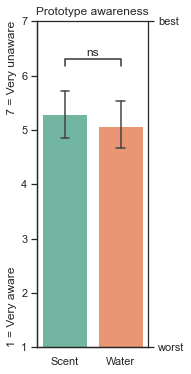

In [33]:
df_final = dfFinal.filter(items=['ID','Condition','Aware_Smells','Aware_Sounds','Aware_Prototype','Wakeup'])
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Aware_Prototype"

#Convert Condition to string so we can use the library
df_final.Condition = df_final.Condition.astype(int).astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_final, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_final, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='1 = Very aware                                             7 = Very unaware', 
       title = 'Prototype awareness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(1,7)
ax2 = ax.twinx()
positions = (7, 0)
labels = ("best", "worst")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'awareness_prototype_mann.png', dpi=300, bbox_inches='tight')

### 2.b) Plots awareness of smell (using statannot)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=1.025e-02 stat=-2.760e+00
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.01025
1-tail p-value statannot:            0.00512
**
-----------------------------------------------------------------------------------


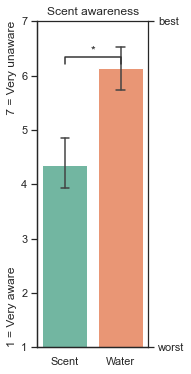

In [34]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Aware_Smells"

#Convert Condition to string so we can use the library
df_final.Condition = df_final.Condition.astype(int).astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_final, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_final, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='1 = Very aware                                             7 = Very unaware', 
       title = 'Scent awareness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(1,7)
ax2 = ax.twinx()
positions = (7, 0)
labels = ("best", "worst")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'awareness_smells_t-test.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=3.311e-03 U_stat=3.950e+01
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.00331
1-tail p-value statannot:            0.00166
**
-----------------------------------------------------------------------------------


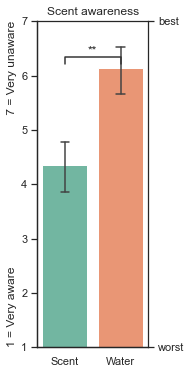

In [35]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Aware_Smells"

#Convert Condition to string so we can use the library
df_final.Condition = df_final.Condition.astype(int).astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_final, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_final, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='outside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='1 = Very aware                                             7 = Very unaware', 
       title = 'Scent awareness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(1,7)
ax2 = ax.twinx()
positions = (7, 0)
labels = ("best", "worst")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'awareness_smells_mann.png', dpi=300, bbox_inches='tight')

### 2.c) Plots awareness of sound (using statannot)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: t-test independent samples, P_val=6.964e-01 stat=3.944e-01
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.69635
1-tail p-value statannot:            0.34818
ns
-----------------------------------------------------------------------------------


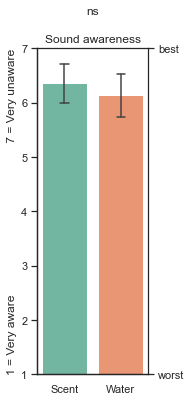

In [36]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Aware_Sounds"

#Convert Condition to string so we can use the library
df_final.Condition = df_final.Condition.astype(int).astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_final, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_final, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='t-test_ind', comparisons_correction=None, text_format='star',
                                  loc='inside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='1 = Very aware                                             7 = Very unaware', 
       title = 'Sound awareness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(1,7)
ax2 = ax.twinx()
positions = (7, 0)
labels = ("best", "worst")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'awareness_sounds_t-test.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided, P_val=5.985e-01 U_stat=1.150e+02
-----------------------------------------------------------------------------------
Plotted 2-tail p-value statannot:    0.59848
1-tail p-value statannot:            0.29924
ns
-----------------------------------------------------------------------------------


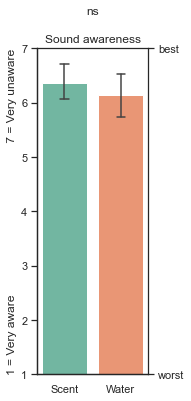

In [37]:
sns.set(style="white")

#Dimmensions of the plot
fig,ax = plt.subplots(figsize=(2,6))

x = "Condition"
y = "Aware_Sounds"

#Convert Condition to string so we can use the library
df_final.Condition = df_final.Condition.astype(int).astype(str)
order = ["0", "1"]

# errwidth - width error bars
# capsize - top & bottom error bars ticks
# palette - colors
# ci - confidence intervals # ci = 68% (+/-1 STD), 95% (+/-2 STD) , 99% (+/-3 STD)      

ax = sns.barplot(data=df_final, x=x, y=y, ax = ax, order=order, errwidth=1.5, capsize=0.15, palette="Set2", ci=68, linewidth = None)
ax, test_results = add_stat_annotation(ax, data=df_final, x=x, y=y, order=order,
                                  box_pairs=[tuple(order)],
                                  test='Mann-Whitney', comparisons_correction=None, text_format='star',
                                  loc='inside', verbose=2)


#baseline is self reported typoical night

ax.set(xlabel='', ylabel='1 = Very aware                                             7 = Very unaware', 
       title = 'Sound awareness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(["Scent","Water"])
ax.axhline(0, linestyle = "--", color = "black", alpha = 0.6)
ax.set_ylim(1,7)
ax2 = ax.twinx()
positions = (7, 0)
labels = ("best", "worst")


plt.yticks(positions, labels)

print("-----------------------------------------------------------------------------------")
print("Plotted 2-tail p-value statannot:   {:8.5f}".format(test_results[0].pval))
print("1-tail p-value statannot:           {:8.5f}".format(test_results[0].pval/2))

if 5.00e-02 < test_results[0].pval/2 <= 1.00e+00:
    print("ns")
if 1.00e-02 < test_results[0].pval/2 <= 5.00e-02:
    print("*")
if 1.00e-03 < test_results[0].pval/2 <= 1.00e-02:
    print("**")
if 1.00e-04 < test_results[0].pval/2 <= 1.00e-03:
    print("***")
if test_results[0].pval/2 <= 1.00e-04:
    print("***")

print("-----------------------------------------------------------------------------------")

plt.savefig(path_plots+'awareness_sounds_mann.png', dpi=300, bbox_inches='tight')